# <center> 6. Ranking </center>

- Ranking algorithms


In [62]:
import numpy as np
import pandas as pd
import scipy.stats

In [63]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

# Data Import

In [64]:
data = pd.read_csv('data/labels.csv', sep=';')
data.head(3)

,query,position,label1,label2
0,1,1,RELEVANT,SOMEWHAT_RELEVANT
1,1,2,SOMEWHAT_RELEVANT,SOMEWHAT_RELEVANT
2,1,3,IRRELEVANT,RELEVANT


In [65]:
# weights
label_dict = {'RELEVANT': 1, 'SOMEWHAT_RELEVANT': 0.5, 'IRRELEVANT': 0};

In [66]:
data['y1'] = data['label1'].apply(lambda x: label_dict[x]);
data['y2'] = data['label2'].apply(lambda x: label_dict[x]);
data.head(3)

,query,position,label1,label2,y1,y2
0,1,1,RELEVANT,SOMEWHAT_RELEVANT,1.0,0.5
1,1,2,SOMEWHAT_RELEVANT,SOMEWHAT_RELEVANT,0.5,0.5
2,1,3,IRRELEVANT,RELEVANT,0.0,1.0


# NDCG

In [67]:
def dcgWeight(k):
    if k < 0:
        return 0
    return 1 / np.log2(k + 1)

In [82]:
def dcg(k, labels):
    if len(labels) < k or k < 0:
        raise Exception('Bad k.')
    return sum([labels[i] * dcgWeight(i + 1) for i in range(k)])


def idcg(k, labels):
    return dcg(k, sorted(labels, reverse=True))


def ndcg(k, labels):
    return dcg(k, labels) / idcg(k, labels)

# pFound

In [69]:
class PFound():
    pBreak = 0.15
    pRel = {'RELEVANT': 0.4, 'SOMEWHAT_RELEVANT': 0.2, 'IRRELEVANT': 0.05}
    
    def __init__(self, data):
        self.data = data
        self.s = 0
        
    def pLook(self, i):
        if i == 0:
            return 1
        return self.pLook(i - 1) * (1 - self.pRel[self.data[i - 1]]) * (1 - self.pBreak)
    
    def pLookSum(self, i):
        if i == 0:
            p = 1
        else:
            p = self.pLookSum(i - 1) * (1 - self.pRel[self.data[i - 1]]) * (1 - self.pBreak)
        self.s += p * self.pRel[self.data[i]]
        return p
    
    def pFoundAtK(self, k):
        self.s = 0
        self.pLookSum(k)

        return self.s

# Calculations

In [70]:
res_ndcg_1 = pd.Series(map(
    lambda x: (lambda y: ndcg(len(y), y))(list(x[1]))
    , data.groupby('query')['y1']
))

In [71]:
res_ndcg_2 = pd.Series(map(
    lambda x: (lambda y: ndcg(len(y), y))(list(x[1]))
    , data.groupby('query')['y2']
))

In [72]:
res_pFound_1 = pd.Series(map(
    lambda x: (lambda y: PFound(y).pFoundAtK(len(y) - 1))(list(x[1]))
    , data.groupby('query')['label1']
))

In [73]:
res_pFound_2 = pd.Series(map(
    lambda x: (lambda y: PFound(y).pFoundAtK(len(y) - 1))(list(x[1]))
    , data.groupby('query')['label2']
))

In [74]:
print(*[res_ndcg_1.mean(), res_ndcg_2.mean(), res_pFound_1.mean(), res_pFound_2.mean()])

0.8109800807451043 0.8526584427294247 0.6699389993273945 0.7089851005678178


In [75]:
resDF = pd.DataFrame({"NDCG_1": res_ndcg_1, "pFound_1": res_pFound_1,
                      "NDCG_2": res_ndcg_2, "pFound_2": res_pFound_2})

In [76]:
resDF.head(5)

,NDCG_1,pFound_1,NDCG_2,pFound_2
0,0.882313,0.717163,0.796370,0.645561
1,0.925624,0.765021,0.839542,0.678255
2,0.979166,0.790113,0.954817,0.771224
3,0.927222,0.758754,0.859537,0.724655
4,0.739064,0.562757,0.811387,0.658731


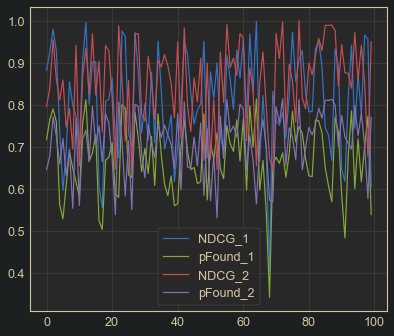

In [77]:
resDF.plot();